In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# mp1.py file
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='Blues')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def visualize_prediction_multi(X, Y):
    fig, axes = plt.subplots(3, 8, figsize=(20, 6))
    axes = axes.flatten()
    for i in range(24):
        ax = axes[i]
        x, y = X[i], Y[i]
        I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
        ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='Blues')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        
        xy = y.reshape(3,2)
        tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 2, alpha = 0.5)
        ax.add_patch(tri)
        
    plt.show()    

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## 1- Simple Classification

In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = to_categorical(Y_train)

[X_test, Y_test] = generate_dataset_classification(300, 20)
Y_test = to_categorical(Y_test, 3)

Creating data:
Creating data:


**Linear Classifier with SGD**

In [5]:
net_sgd = models.Sequential()
net_sgd.add(layers.Dense(3, input_shape=(72*72,), activation='softmax'))  

net_sgd.compile(optimizer=optimizers.SGD(lr=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

batch_size = 32
net_sgd.fit(X_train, Y_train, epochs=50, batch_size=batch_size, 
            validation_data=(X_test, Y_test),verbose=2)
score = net_sgd.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (net_sgd.metrics_names[1], score[1]*100))

Train on 300 samples, validate on 300 samples
Epoch 1/50
 - 0s - loss: 1.0693 - acc: 0.5067 - val_loss: 1.0300 - val_acc: 0.4600
Epoch 2/50
 - 0s - loss: 0.9463 - acc: 0.5833 - val_loss: 0.9586 - val_acc: 0.5567
Epoch 3/50
 - 0s - loss: 0.8731 - acc: 0.6200 - val_loss: 1.1080 - val_acc: 0.3500
Epoch 4/50
 - 0s - loss: 0.8116 - acc: 0.6833 - val_loss: 0.7710 - val_acc: 0.7667
Epoch 5/50
 - 0s - loss: 0.7518 - acc: 0.7200 - val_loss: 0.7403 - val_acc: 0.8133
Epoch 6/50
 - 0s - loss: 0.6967 - acc: 0.7967 - val_loss: 0.8646 - val_acc: 0.6133
Epoch 7/50
 - 0s - loss: 0.6753 - acc: 0.7433 - val_loss: 0.6730 - val_acc: 0.7567
Epoch 8/50
 - 0s - loss: 0.6379 - acc: 0.7833 - val_loss: 0.6536 - val_acc: 0.7833
Epoch 9/50
 - 0s - loss: 0.6421 - acc: 0.7633 - val_loss: 0.6735 - val_acc: 0.6767
Epoch 10/50
 - 0s - loss: 0.6090 - acc: 0.8033 - val_loss: 0.6736 - val_acc: 0.7433
Epoch 11/50
 - 0s - loss: 0.5691 - acc: 0.8267 - val_loss: 0.5799 - val_acc: 0.8433
Epoch 12/50
 - 0s - loss: 0.5575 - acc:

**Linear Classifier with Adam**

In [7]:
net_ad = models.Sequential()
net_ad.add(layers.Dense(3, input_shape=(72*72,), activation='softmax'))  

net_ad.compile(optimizer=optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

batch_size = 32
net_ad.fit(X_train, Y_train, epochs=50, batch_size=batch_size, 
            validation_data=(X_test, Y_test), verbose=2)
score = net_ad.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (net_ad.metrics_names[1], score[1]*100))

Train on 300 samples, validate on 300 samples
Epoch 1/50
 - 0s - loss: 1.4748 - acc: 0.4700 - val_loss: 1.0902 - val_acc: 0.6133
Epoch 2/50
 - 0s - loss: 0.7341 - acc: 0.7033 - val_loss: 0.5088 - val_acc: 0.8033
Epoch 3/50
 - 0s - loss: 0.4359 - acc: 0.8533 - val_loss: 0.4015 - val_acc: 0.8400
Epoch 4/50
 - 0s - loss: 0.3354 - acc: 0.8967 - val_loss: 0.3218 - val_acc: 0.8833
Epoch 5/50
 - 0s - loss: 0.3037 - acc: 0.8967 - val_loss: 0.2806 - val_acc: 0.9233
Epoch 6/50
 - 0s - loss: 0.2787 - acc: 0.9167 - val_loss: 0.2554 - val_acc: 0.8833
Epoch 7/50
 - 0s - loss: 0.2010 - acc: 0.9533 - val_loss: 0.1944 - val_acc: 0.9967
Epoch 8/50
 - 0s - loss: 0.1923 - acc: 0.9533 - val_loss: 0.3348 - val_acc: 0.7867
Epoch 9/50
 - 0s - loss: 0.2032 - acc: 0.9200 - val_loss: 0.1873 - val_acc: 0.9700
Epoch 10/50
 - 0s - loss: 0.1668 - acc: 0.9600 - val_loss: 0.1402 - val_acc: 0.9967
Epoch 11/50
 - 0s - loss: 0.1560 - acc: 0.9500 - val_loss: 0.1494 - val_acc: 0.9933
Epoch 12/50
 - 0s - loss: 0.1464 - acc:

## 2- Visualisation of the solution

In [8]:
#0: rectangle, 1: disk, 2:triangle
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

rectangle = net2.get_weights()[0][:,0].reshape(72,72)
rectangle = normalize(rectangle)

disk = net2.get_weights()[0][:,1].reshape(72,72)
disk = normalize(disk)

triangle = net2.get_weights()[0][:,2].reshape(72,72)
triangle = normalize(triangle)

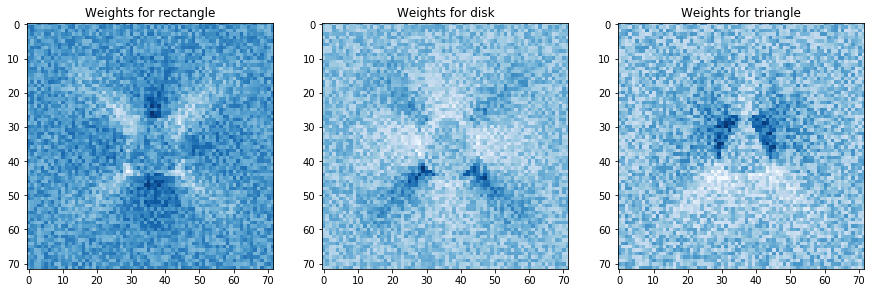

In [9]:
shapes, data = ['rectangle', 'disk', 'triangle'], [rectangle, disk, triangle]
fig, axs = plt.subplots(1, 3, figsize=(15,15))

for i in range(3):
    axs[i].imshow(data[i], cmap='Blues')
    axs[i].set_title('Weights for '+shapes[i])

## 3- A More Difficult Classification Problem

In [10]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = to_categorical(Y_train)

[X_test, Y_test] = generate_dataset_classification(300, 20, True)
Y_test = to_categorical(Y_test, 3)

Creating data:
Creating data:


**Linear model with SGD**

In [11]:
net_sgd2 = models.Sequential()
net_sgd2.add(layers.Dense(3, input_shape=(72*72,), activation='softmax'))  

net_sgd2.compile(optimizer=optimizers.SGD(lr=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

batch_size = 32
net_sgd2.fit(X_train, Y_train, epochs=50, batch_size=batch_size, 
            validation_data=(X_test, Y_test),verbose=2)
score = net_sgd2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (net_sgd2.metrics_names[1], score[1]*100))

Train on 300 samples, validate on 300 samples
Epoch 1/50
 - 0s - loss: 1.2807 - acc: 0.3233 - val_loss: 1.3256 - val_acc: 0.3367
Epoch 2/50
 - 0s - loss: 1.1907 - acc: 0.3333 - val_loss: 1.1865 - val_acc: 0.3400
Epoch 3/50
 - 0s - loss: 1.0935 - acc: 0.4167 - val_loss: 1.2696 - val_acc: 0.3367
Epoch 4/50
 - 0s - loss: 1.0544 - acc: 0.4533 - val_loss: 1.1378 - val_acc: 0.4100
Epoch 5/50
 - 0s - loss: 1.0788 - acc: 0.4167 - val_loss: 1.2370 - val_acc: 0.3800
Epoch 6/50
 - 0s - loss: 1.0131 - acc: 0.4900 - val_loss: 1.0723 - val_acc: 0.4700
Epoch 7/50
 - 0s - loss: 1.0018 - acc: 0.5133 - val_loss: 1.0628 - val_acc: 0.4167
Epoch 8/50
 - 0s - loss: 0.9757 - acc: 0.5200 - val_loss: 1.0648 - val_acc: 0.4900
Epoch 9/50
 - 0s - loss: 0.9852 - acc: 0.5100 - val_loss: 1.1471 - val_acc: 0.4000
Epoch 10/50
 - 0s - loss: 0.9505 - acc: 0.5333 - val_loss: 1.0849 - val_acc: 0.4800
Epoch 11/50
 - 0s - loss: 0.9300 - acc: 0.5367 - val_loss: 1.0971 - val_acc: 0.4667
Epoch 12/50
 - 0s - loss: 0.9397 - acc:

**Linear model with Adam**

In [12]:
net_ad2 = models.Sequential()
net_ad2.add(layers.Dense(3, input_shape=(72*72,), activation='softmax'))  

net_ad2.compile(optimizer=optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

batch_size = 32
net_ad2.fit(X_train, Y_train, epochs=50, batch_size=batch_size, 
            validation_data=(X_test, Y_test),verbose=2)
score = net_ad2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (net_ad2.metrics_names[1], score[1]*100))

Train on 300 samples, validate on 300 samples
Epoch 1/50
 - 0s - loss: 2.6732 - acc: 0.3533 - val_loss: 2.4041 - val_acc: 0.3367
Epoch 2/50
 - 0s - loss: 1.8373 - acc: 0.4333 - val_loss: 1.9515 - val_acc: 0.4700
Epoch 3/50
 - 0s - loss: 1.5924 - acc: 0.3600 - val_loss: 1.2528 - val_acc: 0.4867
Epoch 4/50
 - 0s - loss: 1.2261 - acc: 0.4233 - val_loss: 0.9987 - val_acc: 0.4767
Epoch 5/50
 - 0s - loss: 1.1222 - acc: 0.5233 - val_loss: 1.1388 - val_acc: 0.5000
Epoch 6/50
 - 0s - loss: 1.0646 - acc: 0.5500 - val_loss: 1.0809 - val_acc: 0.5067
Epoch 7/50
 - 0s - loss: 1.0208 - acc: 0.5667 - val_loss: 1.2641 - val_acc: 0.5300
Epoch 8/50
 - 0s - loss: 0.9763 - acc: 0.5533 - val_loss: 1.0346 - val_acc: 0.5567
Epoch 9/50
 - 0s - loss: 0.8509 - acc: 0.5967 - val_loss: 1.0239 - val_acc: 0.4933
Epoch 10/50
 - 0s - loss: 0.7862 - acc: 0.6000 - val_loss: 0.8768 - val_acc: 0.5567
Epoch 11/50
 - 0s - loss: 0.7367 - acc: 0.6600 - val_loss: 0.8767 - val_acc: 0.5633
Epoch 12/50
 - 0s - loss: 0.7185 - acc:

**CNN with SGD**

In [14]:
conv_sgd = models.Sequential()
conv_sgd.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(72,72,1))) 
conv_sgd.add(layers.MaxPooling2D((2, 2)))
conv_sgd.add(layers.Flatten())
conv_sgd.add(layers.Dense(64, activation='relu'))
conv_sgd.add(layers.Dense(3, activation='softmax'))

conv_sgd.compile(optimizer=optimizers.SGD(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

conv_sgd.fit(X_train.reshape((300,72,72,1)),Y_train, epochs=30, batch_size=32, 
            validation_data=(X_test.reshape((300,72,72,1)), Y_test), verbose=2)
score = conv_sgd.evaluate(X_test.reshape((300,72,72,1)), Y_test, verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (conv_sgd.metrics_names[1], score[1]*100))

Train on 300 samples, validate on 300 samples
Epoch 1/30
 - 2s - loss: 1.0979 - acc: 0.3667 - val_loss: 1.0863 - val_acc: 0.4400
Epoch 2/30
 - 1s - loss: 1.0828 - acc: 0.4333 - val_loss: 1.0859 - val_acc: 0.4300
Epoch 3/30
 - 1s - loss: 1.0770 - acc: 0.3633 - val_loss: 1.0869 - val_acc: 0.3233
Epoch 4/30
 - 1s - loss: 1.0695 - acc: 0.4367 - val_loss: 1.0797 - val_acc: 0.4400
Epoch 5/30
 - 1s - loss: 1.0565 - acc: 0.4900 - val_loss: 1.0810 - val_acc: 0.3267
Epoch 6/30
 - 1s - loss: 1.0508 - acc: 0.4233 - val_loss: 1.0612 - val_acc: 0.4467
Epoch 7/30
 - 1s - loss: 1.0493 - acc: 0.4400 - val_loss: 1.0711 - val_acc: 0.3367
Epoch 8/30
 - 1s - loss: 1.0327 - acc: 0.5067 - val_loss: 1.0496 - val_acc: 0.4833
Epoch 9/30
 - 1s - loss: 1.0279 - acc: 0.5133 - val_loss: 1.0495 - val_acc: 0.4233
Epoch 10/30
 - 1s - loss: 1.0233 - acc: 0.5233 - val_loss: 1.0458 - val_acc: 0.4300
Epoch 11/30
 - 1s - loss: 1.0141 - acc: 0.5433 - val_loss: 1.0428 - val_acc: 0.4433
Epoch 12/30
 - 1s - loss: 1.0071 - acc:

**CNN with Adam**

In [15]:
conv_ad = models.Sequential()
conv_ad.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(72,72,1))) 
conv_ad.add(layers.MaxPooling2D((2, 2)))
conv_ad.add(layers.Flatten())
conv_ad.add(layers.Dense(64, activation='relu'))
conv_ad.add(layers.Dense(3, activation='softmax'))

conv_ad.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

conv_ad.fit(X_train.reshape((300,72,72,1)),Y_train, epochs=30, batch_size=32, 
            validation_data=(X_test.reshape((300,72,72,1)), Y_test), verbose=2)
score = conv_ad.evaluate(X_test.reshape((300,72,72,1)), Y_test, verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (conv_ad.metrics_names[1], score[1]*100))

Train on 300 samples, validate on 300 samples
Epoch 1/30
 - 2s - loss: 3.3226 - acc: 0.4067 - val_loss: 1.1097 - val_acc: 0.3367
Epoch 2/30
 - 1s - loss: 1.2795 - acc: 0.3767 - val_loss: 1.2582 - val_acc: 0.4667
Epoch 3/30
 - 1s - loss: 0.9266 - acc: 0.6200 - val_loss: 0.9029 - val_acc: 0.6233
Epoch 4/30
 - 1s - loss: 0.7400 - acc: 0.7533 - val_loss: 0.8267 - val_acc: 0.6433
Epoch 5/30
 - 1s - loss: 0.7162 - acc: 0.7167 - val_loss: 1.0210 - val_acc: 0.4867
Epoch 6/30
 - 1s - loss: 0.6770 - acc: 0.6867 - val_loss: 0.7819 - val_acc: 0.7000
Epoch 7/30
 - 2s - loss: 0.5740 - acc: 0.8233 - val_loss: 0.7822 - val_acc: 0.6433
Epoch 8/30
 - 1s - loss: 0.5172 - acc: 0.8733 - val_loss: 0.7407 - val_acc: 0.7200
Epoch 9/30
 - 1s - loss: 0.4768 - acc: 0.8600 - val_loss: 0.7387 - val_acc: 0.6767
Epoch 10/30
 - 1s - loss: 0.4561 - acc: 0.8700 - val_loss: 0.7636 - val_acc: 0.6800
Epoch 11/30
 - 1s - loss: 0.4241 - acc: 0.8833 - val_loss: 0.6990 - val_acc: 0.7233
Epoch 12/30
 - 1s - loss: 0.3823 - acc:

## 4-Triangle location predictions

We order the points of triangles by their y coordinate

In [17]:
def sort_y(vertices):
    Y_temp = np.array(vertices)
    Y_temp = Y_temp.reshape((3, 2))
    Y_temp = Y_temp[Y_temp[:,-1].argsort()].flatten()
    return Y_temp


[X_train, Y_train] = generate_dataset_regression(300, 20)
Y_train_s = np.array([sort_y(vertices) for vertices in Y_train])
[X_test, Y_test] = generate_dataset_regression(300, 20)
Y_test_s = np.array([sort_y(vertices) for vertices in Y_test])

Creating data:
Creating data:


In [22]:
conv_s = models.Sequential()
conv_s.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 1), padding='same'))
conv_s.add(layers.MaxPooling2D(pool_size=(4, 4), padding='same'))
conv_s.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
conv_s.add(layers.MaxPooling2D(pool_size=(4, 4), padding='same'))
conv_s.add(layers.Flatten())
conv_s.add(layers.Dense(128, activation='relu'))
conv_s.add(layers.Dense(6))
conv_s.compile(optimizer='adam', loss='mae',metrics=['accuracy'])
conv_s.fit(X_train.reshape((300,72,72,1)),
          Y_train_s, epochs=30, batch_size=32, validation_data=(X_test.reshape((300,72,72,1))
                                                             , Y_test_s), verbose=2)

Train on 300 samples, validate on 300 samples
Epoch 1/30
 - 6s - loss: 0.2653 - acc: 0.4633 - val_loss: 0.2012 - val_acc: 0.4800
Epoch 2/30
 - 6s - loss: 0.1977 - acc: 0.5400 - val_loss: 0.1760 - val_acc: 0.4800
Epoch 3/30
 - 5s - loss: 0.1692 - acc: 0.5633 - val_loss: 0.1511 - val_acc: 0.5200
Epoch 4/30
 - 6s - loss: 0.1520 - acc: 0.6000 - val_loss: 0.1454 - val_acc: 0.5300
Epoch 5/30
 - 5s - loss: 0.1378 - acc: 0.6267 - val_loss: 0.1319 - val_acc: 0.5167
Epoch 6/30
 - 6s - loss: 0.1276 - acc: 0.6100 - val_loss: 0.1242 - val_acc: 0.5467
Epoch 7/30
 - 6s - loss: 0.1207 - acc: 0.6433 - val_loss: 0.1178 - val_acc: 0.5633
Epoch 8/30
 - 5s - loss: 0.1148 - acc: 0.6633 - val_loss: 0.1111 - val_acc: 0.6433
Epoch 9/30
 - 5s - loss: 0.1089 - acc: 0.7100 - val_loss: 0.1126 - val_acc: 0.6400
Epoch 10/30
 - 5s - loss: 0.0994 - acc: 0.7133 - val_loss: 0.1068 - val_acc: 0.6300
Epoch 11/30
 - 5s - loss: 0.0911 - acc: 0.7267 - val_loss: 0.1019 - val_acc: 0.6633
Epoch 12/30
 - 6s - loss: 0.0873 - acc:

Test loss: 0.0769811823964119
Test acc: 75.67%


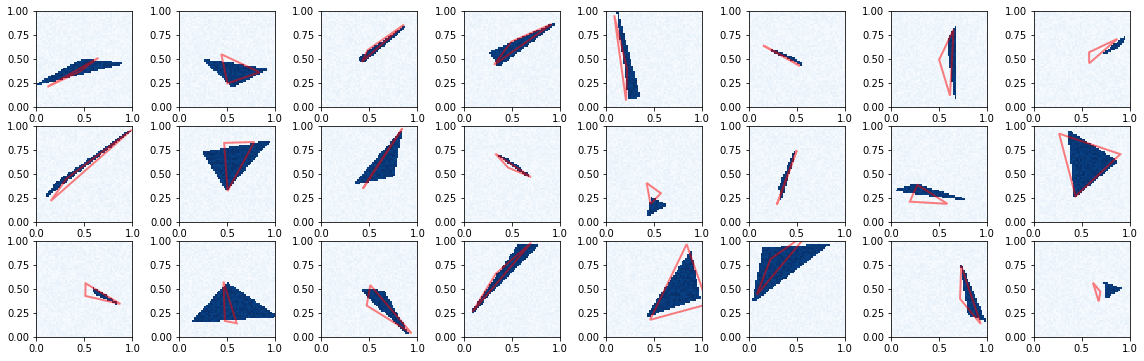

In [24]:
score = conv_s.evaluate(X_test.reshape((300,72,72,1)), Y_test_s, verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (conv_s.metrics_names[1], score[1]*100))
Y_pred_s = conv_s.predict(X_test.reshape((300,72,72,1)))
visualize_prediction_multi(1-X_test, Y_pred_s)

## 5- Image denoising

In [48]:
def generate_noisy_dataset(nb_samples, noise=50.0, free_location=False):
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0.0, free_location)
            X[i] = Y[i] + noise * np.random.randn(Y[i].size)
        elif category == 1: 
            Y[i] = generate_a_disk(0.0, free_location)
            X[i] = Y[i] + noise * np.random.randn(Y[i].size)
        else:
            Y[i], _ = generate_a_triangle(0.0, free_location)
            X[i] = Y[i] + noise * np.random.randn(Y[i].size)
    return [np.clip(X/255, 0., 1.), Y/255]

In [49]:
[X_noisy_train, X_true_train] = generate_noisy_dataset(300, free_location=False)
[X_noisy_test, X_true_test] = generate_noisy_dataset(300, free_location=False)

Creating data:
Creating data:


first row: noisy shapes, second row: original shapes


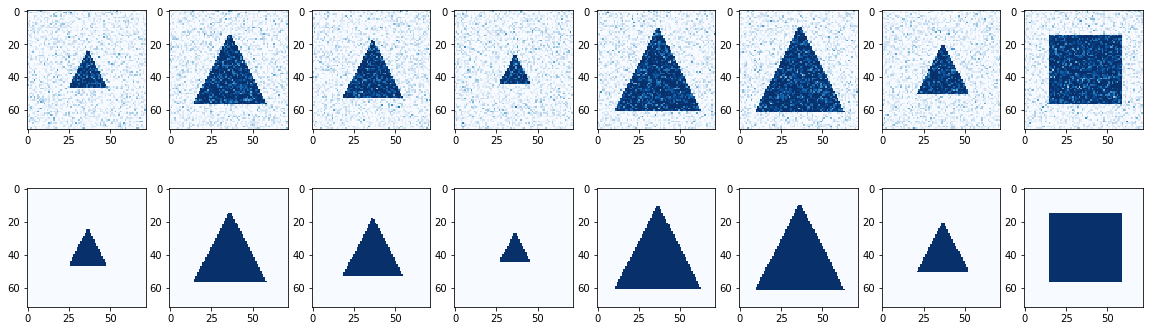

In [50]:
fig, axs = plt.subplots(2, 8, figsize=(20,6))
print('first row: noisy shapes, second row: original shapes')
for i in range(8):
  axs[0,i].imshow(1-X_noisy_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues', label='noisy')
  axs[1,i].imshow(1-X_true_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')


In [66]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.models import Model

def train_autoencoder(x_noisy_train, x_true_train, x_noisy_test, x_true_test, epochs=30, batch_size=32):
    input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mae',metrics=['accuracy'])

    autoencoder.fit(x_noisy_train, x_true_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_noisy_test, x_true_test))

    return autoencoder

In [67]:
denoise = train_autoencoder(X_noisy_train.reshape(300,72,72,1), X_true_train.reshape(300,72,72,1), 
                      X_noisy_test.reshape(300,72,72,1), X_true_test.reshape(300,72,72,1))
score = denoise.evaluate(X_noisy_test.reshape((300,72,72,1)), X_true_test.reshape((300,72,72,1)), verbose=0)
print('Test loss:', score[0])
print("Test %s: %.2f%%" % (denoise.metrics_names[1], score[1]*100))

Train on 300 samples, validate on 300 samples
Epoch 1/30
300/300 [==============================] - 30s 101ms/step - loss: 0.4702 - acc: 0.7652 - val_loss: 0.4032 - val_acc: 0.7684
Epoch 2/30
300/300 [==============================] - 28s 92ms/step - loss: 0.3101 - acc: 0.7914 - val_loss: 0.2233 - val_acc: 0.7772
Epoch 3/30
300/300 [==============================] - 35s 116ms/step - loss: 0.2026 - acc: 0.7924 - val_loss: 0.2110 - val_acc: 0.7772
Epoch 4/30
300/300 [==============================] - 29s 98ms/step - loss: 0.1903 - acc: 0.7924 - val_loss: 0.1855 - val_acc: 0.7772
Epoch 5/30
300/300 [==============================] - 32s 105ms/step - loss: 0.1618 - acc: 0.8274 - val_loss: 0.1508 - val_acc: 0.8811
Epoch 6/30
300/300 [==============================] - 27s 91ms/step - loss: 0.1262 - acc: 0.9243 - val_loss: 0.1040 - val_acc: 0.9548
Epoch 7/30
300/300 [==============================] - 24s 80ms/step - loss: 0.0737 - acc: 0.9758 - val_loss: 0.0455 - val_acc: 0.9868
Epoch 8/30
30

In [68]:
X_pred = denoise.predict(X_noise_test.reshape(300,72,72,1))

First row: Noisy shapes
Second row: True shapes
Third row: Filtered shapes


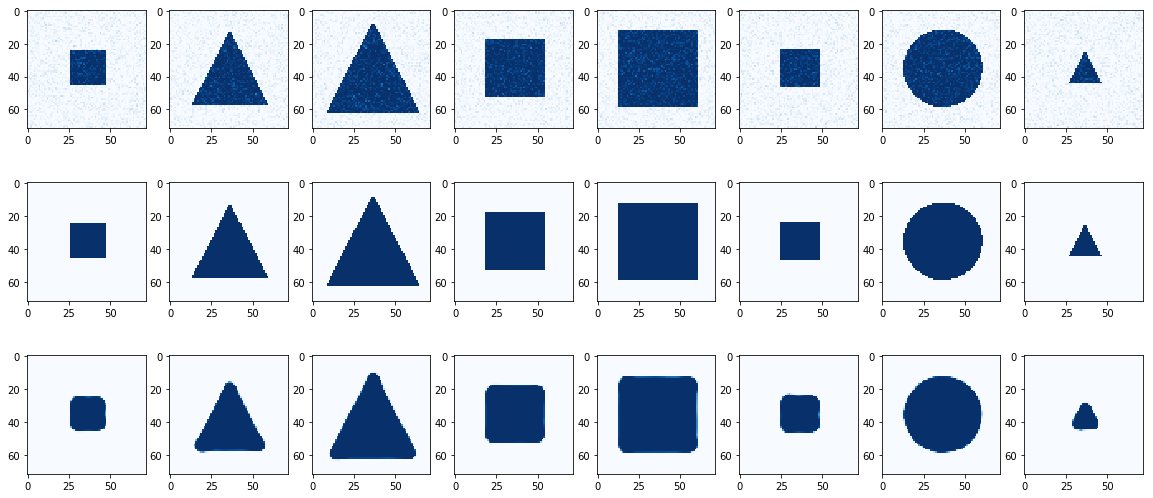

In [72]:
fig, axs = plt.subplots(3, 8, figsize=(20,9))
print('First row: Noisy shapes\nSecond row: True shapes\nThird row: Filtered shapes')
for i in range(8):
  axs[0,i].imshow(1-X_noise_test[2*i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
  axs[1,i].imshow(1-X_good_test[2*i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
  axs[2,i].imshow(1-X_pred[2*i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')